Found 700 images belonging to 5 classes.
Found 150 images belonging to 5 classes.
Found 150 images belonging to 5 classes.
Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.3468 - loss: 1.7438 - val_accuracy: 0.7344 - val_loss: 0.8532
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.4688 - loss: 1.0798 - val_accuracy: 0.4545 - val_loss: 1.0230
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.6781 - loss: 0.8448 - val_accuracy: 0.8125 - val_loss: 0.5253
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7188 - loss: 0.7298 - val_accuracy: 0.7727 - val_loss: 0.5636
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.7832 - loss: 0.6023 - val_accuracy: 0.8672 - val_loss: 0.3665
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8750 - loss: 0.2432 - val_accuracy: 0.8182 - val_loss: 0.3949
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.8545 - loss: 0.3588 - val_accuracy: 0.8828 - val_loss:

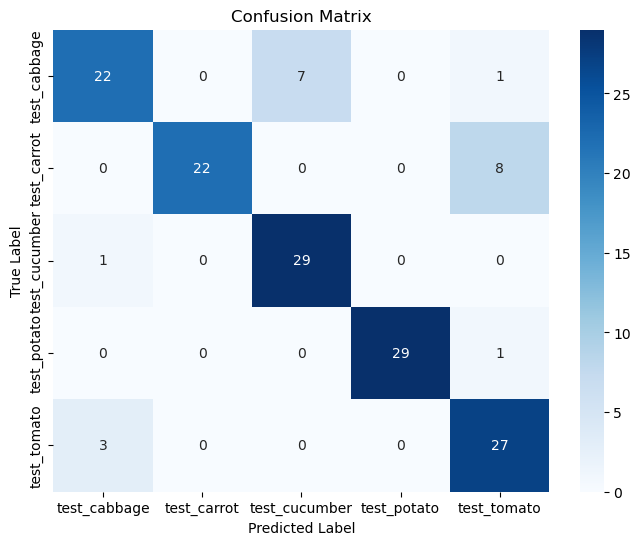

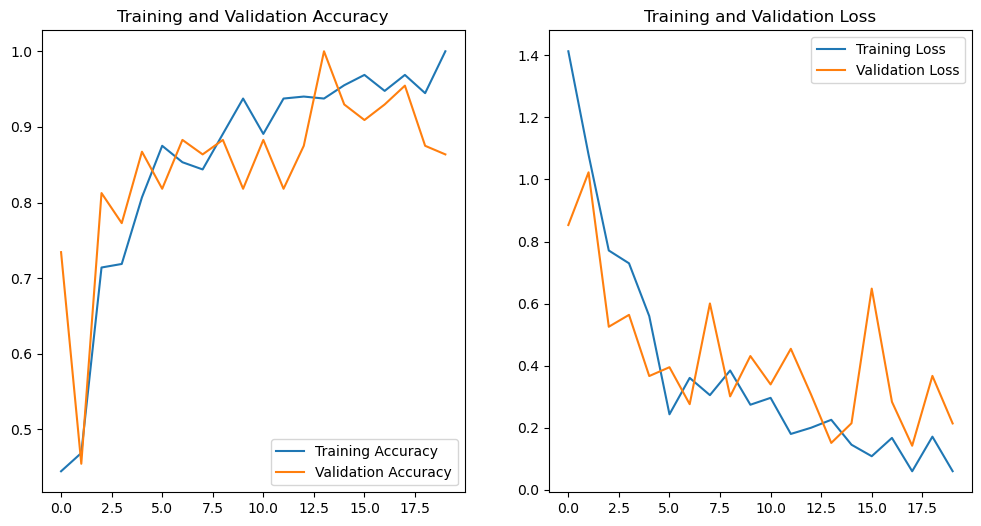

In [2]:
# Step 0: Import necessary libraries
import os
import json
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import warnings

# Suppress UserWarnings
warnings.filterwarnings('ignore', category=UserWarning)

# Step 1: Load dataset path from config.json
config_path = './config.json'  # Ensure this file is in the same directory as your notebook

if not os.path.exists(config_path):
    raise FileNotFoundError(f"{config_path} not found. Please create a config.json file with the dataset path.")

with open(config_path) as config_file:
    config = json.load(config_file)

base_dir = config['dataset_path']  # Path to dataset
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Step 2: Image dimensions and batch size
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# Step 3: Data Preprocessing and Normalization
train_datagen = ImageDataGenerator(rescale=1.0/255)
val_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Step 4: Load the data from the directories
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Ensure shuffle=False for confusion matrix and evaluation
)

# Step 5: Building a CNN model
model = models.Sequential([
    layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),  # Explicitly define the input shape
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Dropout to prevent overfitting
    layers.Dense(5, activation='softmax')  # 5 classes for 5 vegetables
])

# Step 6: Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Step 7: Train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,  # Change the number of epochs as needed
    steps_per_epoch=train_data.samples // BATCH_SIZE,
    validation_steps=val_data.samples // BATCH_SIZE
)

# Step 8: Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_data)
print('Test accuracy:', test_acc)

# Step 9: Get predictions and calculate metrics
Y_pred = model.predict(test_data)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_data.classes

# Generate classification report
class_labels = list(test_data.class_indices.keys())
print('Classification Report:')
print(classification_report(y_true, y_pred, target_names=class_labels))

# Step 10: Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Step 11: Plot accuracy and loss over epochs
# Adjust the epochs range based on the number of epochs trained
num_epochs = len(history.history['accuracy'])  # Number of epochs based on training history
epochs_range = range(num_epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
